In [1]:
from numpy.random import seed
seed(101)
import tensorflow
tensorflow.random.set_seed(101)

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
os.listdir ('../Heridas')

['ImagenesAProcesar-20200727T214422Z-001.zip',
 'Proyecto CNN Heridas.odp',
 'training_1',
 'Venosas',
 'model.h5',
 'procesar',
 'Pioderma Gangrenoso',
 '.ipynb_checkpoints',
 'Arteriales',
 'MARTORELL',
 'Clasificación heridas.ipynb',
 'Untitled.ipynb']

In [10]:
print(len(os.listdir('procesar/originales/train/lpp')))
print(len(os.listdir('procesar/originales/train/pie')))
print(len(os.listdir('procesar/originales/train/vasculares')))

19
25
42


In [14]:
print(len(os.listdir('procesar/originales/train/lpp')))
print(len(os.listdir('procesar/originales/train/pie')))
print(len(os.listdir('procesar/originales/train/vasculares')))

209
275
462


In [4]:
print(len(os.listdir('procesar/originales/val/lpp')))
print(len(os.listdir('procesar/originales/val/pie')))
print(len(os.listdir('procesar/originales/val/vasculares')))

4
6
8


In [12]:
# Crear un directorio para las categorias que hago augmentation


categorias = ['lpp','pie','vasculares']

In [13]:
for categoria in categorias:
    
    
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_class = categoria

    img_list = os.listdir('procesar/originales/train/' + img_class)

    for fname in img_list:
            src = os.path.join('procesar/originales/train/' + img_class, fname)
            dst = os.path.join(img_dir, fname)
            shutil.copyfile(src, dst)

    path = aug_dir
    save_path = 'procesar/originales/train/' + img_class

    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)


    num_aug_images_wanted = 500 
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    for i in range(0,num_batches):
        imgs, labels = next(aug_datagen)
        
    shutil.rmtree('aug_dir')

Found 19 images belonging to 1 classes.
Found 25 images belonging to 1 classes.
Found 42 images belonging to 1 classes.


In [5]:
train_path = 'procesar/originales/train'
val_path = 'procesar/originales/val'

In [6]:
train_samples = 946
val_samples = 18

In [7]:
train_batch_size = 10
val_batch_size = 10
image_size = 224

In [8]:
train_steps = np.ceil (train_samples / train_batch_size)
val_steps = np.ceil (val_samples / val_batch_size)

In [10]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

In [11]:
train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

Found 946 images belonging to 3 classes.


In [12]:
valid_batches = datagen.flow_from_directory(val_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

Found 18 images belonging to 3 classes.


In [13]:
test_batches = datagen.flow_from_directory(val_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 18 images belonging to 3 classes.


In [15]:
mobile_net = tensorflow.keras.applications.mobilenet.MobileNet()

In [16]:
len (mobile_net.layers)

93

In [17]:
# Arquitectura del modelo

# Excluir las ultimas 5 capas del modelo
# Incluye hasta global_average_pooling2d

x = mobile_net.layers [-6].output

# Crear una nueva capa densa para predicciones. 3 categorías

x = Dropout (0.25)(x) # Dropout reduce el overfitting al train

predictions = Dense (3, activation = 'softmax')(x)

model = Model (inputs = mobile_net.input, outputs = predictions)

In [18]:
model.summary ()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [19]:
len (model.layers)

90

In [20]:
# Elección de capas a ser entrenadas, las ultimas 23

# Las demas no se entrenan

for layer in mobile_net.layers [:-23]:
    layer.trainable = False

In [5]:
def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)
    
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [22]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [23]:
print(valid_batches.class_indices)

{'lpp': 0, 'pie': 1, 'vasculares': 2}


In [24]:
class_weights={
    0: 2.0, # lpp
    1: 1.0, # pie
    2: 1.0, # vasculares    
}

In [27]:
#checkpoint_path = "training_1/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=75, verbose=1,
                   callbacks=callbacks_list)


model.save('my_model.h5') 

Epoch 1/75
95/95 [==============================] - ETA: 0s - loss: 0.0040 - categorical_accuracy: 1.0000 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00001: val_top_3_accuracy improved from -inf to 1.00000, saving model to model.h5
95/95 [==============================] - 54s 567ms/step - loss: 0.0040 - categorical_accuracy: 1.0000 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 0.8543 - val_categorical_accuracy: 0.8333 - val_top_2_accuracy: 0.9444 - val_top_3_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 2/75
95/95 [==============================] - ETA: 0s - loss: 0.0044 - categorical_accuracy: 0.9989 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00002: val_top_3_accuracy did not improve from 1.00000
95/95 [==============================] - 55s 579ms/step - loss: 0.0044 - categorical_accuracy: 0.9989 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 0.8482 - val_categorical_accuracy: 0.8333 - val_top_2_accuracy: 0.9444 - val_top_3_accuracy: 1

Epoch 18/75
95/95 [==============================] - ETA: 0s - loss: 0.0022 - categorical_accuracy: 1.0000 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00018: val_top_3_accuracy did not improve from 1.00000
95/95 [==============================] - 51s 536ms/step - loss: 0.0022 - categorical_accuracy: 1.0000 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 0.8602 - val_categorical_accuracy: 0.8333 - val_top_2_accuracy: 0.9444 - val_top_3_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 19/75
95/95 [==============================] - ETA: 0s - loss: 0.0064 - categorical_accuracy: 0.9979 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00019: val_top_3_accuracy did not improve from 1.00000
95/95 [==============================] - 53s 553ms/step - loss: 0.0064 - categorical_accuracy: 0.9979 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 0.8586 - val_categorical_accuracy: 0.8333 - val_top_2_accuracy: 0.9444 - val_top_3_accuracy: 1.0000 - lr: 1.0000e-05
Ep

Epoch 35/75
95/95 [==============================] - ETA: 0s - loss: 0.0031 - categorical_accuracy: 0.9979 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00035: val_top_3_accuracy did not improve from 1.00000
95/95 [==============================] - 51s 537ms/step - loss: 0.0031 - categorical_accuracy: 0.9979 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 0.8644 - val_categorical_accuracy: 0.8333 - val_top_2_accuracy: 0.9444 - val_top_3_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 36/75
95/95 [==============================] - ETA: 0s - loss: 0.0036 - categorical_accuracy: 0.9989 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00036: val_top_3_accuracy did not improve from 1.00000
95/95 [==============================] - 51s 537ms/step - loss: 0.0036 - categorical_accuracy: 0.9989 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 0.8670 - val_categorical_accuracy: 0.8333 - val_top_2_accuracy: 0.9444 - val_top_3_accuracy: 1.0000 - lr: 1.0000e-05
Ep

Epoch 52/75
95/95 [==============================] - ETA: 0s - loss: 0.0023 - categorical_accuracy: 1.0000 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00052: val_top_3_accuracy did not improve from 1.00000
95/95 [==============================] - 51s 533ms/step - loss: 0.0023 - categorical_accuracy: 1.0000 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 0.8153 - val_categorical_accuracy: 0.8333 - val_top_2_accuracy: 0.9444 - val_top_3_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 53/75
95/95 [==============================] - ETA: 0s - loss: 0.0023 - categorical_accuracy: 0.9989 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00053: val_top_3_accuracy did not improve from 1.00000
95/95 [==============================] - 51s 536ms/step - loss: 0.0023 - categorical_accuracy: 0.9989 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 0.8438 - val_categorical_accuracy: 0.8333 - val_top_2_accuracy: 0.9444 - val_top_3_accuracy: 1.0000 - lr: 1.0000e-05
Ep

Epoch 69/75
95/95 [==============================] - ETA: 0s - loss: 0.1308 - categorical_accuracy: 0.9947 - top_2_accuracy: 0.9968 - top_3_accuracy: 1.0000
Epoch 00069: val_top_3_accuracy did not improve from 1.00000
95/95 [==============================] - 51s 533ms/step - loss: 0.1308 - categorical_accuracy: 0.9947 - top_2_accuracy: 0.9968 - top_3_accuracy: 1.0000 - val_loss: 0.8562 - val_categorical_accuracy: 0.8333 - val_top_2_accuracy: 0.9444 - val_top_3_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 70/75
95/95 [==============================] - ETA: 0s - loss: 0.0096 - categorical_accuracy: 0.9979 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000
Epoch 00070: val_top_3_accuracy did not improve from 1.00000
95/95 [==============================] - 50s 530ms/step - loss: 0.0096 - categorical_accuracy: 0.9979 - top_2_accuracy: 1.0000 - top_3_accuracy: 1.0000 - val_loss: 0.8783 - val_categorical_accuracy: 0.8333 - val_top_2_accuracy: 0.9444 - val_top_3_accuracy: 1.0000 - lr: 1.0000e-05
Ep

In [6]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

ValueError: Unknown metric function: top_2_accuracy

In [4]:
dependencies = {
    'valid_accuracy': ValidAccuracy
}

NameError: name 'ValidAccuracy' is not defined

In [31]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

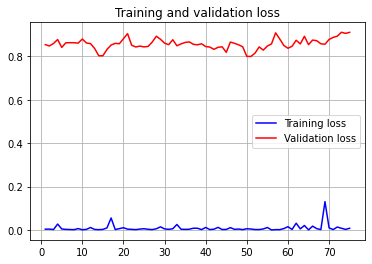

<Figure size 432x288 with 0 Axes>

In [32]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.figure()

plt.show ()

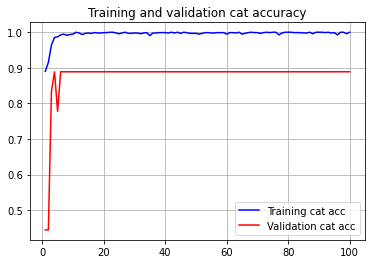

<Figure size 432x288 with 0 Axes>

In [44]:
plt.plot(epochs, acc, 'b', label='Training cat acc')
plt.plot(epochs, val_acc, 'r', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.grid ()
plt.figure()

plt.show ()

In [33]:
test_labels = test_batches.classes

In [34]:
test_batches.class_indices

{'lpp': 0, 'pie': 1, 'vasculares': 2}

In [35]:
predictions = model.predict(test_batches, steps= (val_samples), verbose=1)

18/18 [==============================] - 1s 55ms/step


In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Matriz de confusión')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Obtenidos')
    plt.xlabel('Predichos')
    plt.tight_layout()

In [41]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Matriz de confusión
[[3 1 0]
 [0 6 0]
 [0 2 6]]


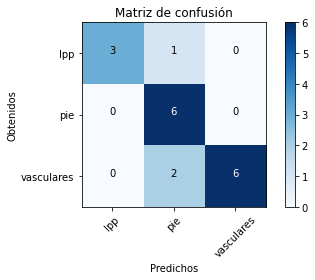

In [42]:
cm_plot_labels = ['lpp', 'pie', 'vasculares']


plot_confusion_matrix(cm, cm_plot_labels, title='Matriz de confusión')


In [48]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [49]:
# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

         lpp       1.00      0.75      0.86         4
         pie       0.67      1.00      0.80         6
  vasculares       1.00      0.75      0.86         8

    accuracy                           0.83        18
   macro avg       0.89      0.83      0.84        18
weighted avg       0.89      0.83      0.84        18



In [50]:
# create a directory to store the model files
os.mkdir('tfjs_dir')

# convert to Tensorflow.js
import tensorflowjs as tfjs

# Error
# AttributeError: module 'tensorflow.python.data.ops.dataset_ops' 
    # has no attribute 'UnaryDataset'

tfjs.converters.save_keras_model(model, 'tfjs_dir')

ModuleNotFoundError: No module named 'tensorflowjs'

In [43]:
def image_classify(model, pak, img, top_n=3):
    """Classify image and return top matches."""
    target_size = (224, 224)
    if img.size != target_size:
        img = img.resize(target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = pak.preprocess_input(x)
    preds = model.predict(x)
    return pak.decode_predictions(preds, top=top_n)[0]

In [44]:
def plot_preds(img, preds_arr):
    """Plot image and its prediction."""
    sns.set_color_codes('pastel')
    f, axarr = plt.subplots(1, len(preds_arr) + 1, figsize=(20, 5))
    axarr[0].imshow(img)
    axarr[0].axis('off')
    for i in range(len(preds_arr)):
        _, x_label, y_label = zip(*(preds_arr[i][1]))
        plt.subplot(1, len(preds_arr) + 1, i + 2)
        ax = sns.barplot(np.array(y_label), np.array(x_label))
        plt.xlim(0, 1)
        ax.set()
        plt.xlabel(preds_arr[i][0])
    plt.show()

In [45]:
def classify_and_plot(image_path):
    """Classify an image with model.
    Plot it and its predicitons.
    """
    img = Image.open(image_path)
    model = image_classify(resnet_model, resnet50, img)
    preds_arr = ('model.h5', model)
    plot_preds(img, preds_arr)

In [47]:
classify_and_plot('procesar/originales/val/vasculares/IMG_0141.JPG')

NameError: name 'Image' is not defined